In [346]:
import tensorflow as tf
import jax
import flax
from flax import linen as nn
from jax import numpy as jnp
from jax import random
from einops import einsum, rearrange, reduce
import optax
import matplotlib.pyplot as plt
import pickle
import time
import numpy as np
from flax.training import orbax_utils

import orbax.checkpoint

import functools


import os
import uuid
import datetime

from maze_dataset.plotting import MazePlot
from maze_dataset.tokenization.token_utils import strings_to_coords

from dataset import CustomMazeDataset
from dataset import NumpyLoader

from model import TransformerLM, TransformerConfig


In [347]:

# config details
checkpoint_path = "data/2023-10-31_16-24-46"
base_path = "data"
save = True

np_seed = 0
jnp_seed = 0

batch_size = 128
lr = 1e-4
n_train_steps = 10000000

save_every_n_steps = 1000
keep_n_checkpoints = 100

n_worker = 8

# n_eval = 1024
emb_dim: int = 256
num_heads: int = 16
num_layers: int = 12
qkv_dim: int = 256  # 512
mlp_dim: int = 1024  # 2048
max_len = 256

grid_n = 5

In [348]:



@jax.jit
def train_step(state, batch):
    params = state['params']
    opt_state = state['opt_state']
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, opt_state = tx.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    step = state['step'] + 1

    return {'params': params, 'opt_state': opt_state, 'loss': loss, 'step': step}

@jax.jit
def eval_step(state, batch):
    params = state['params']
    loss = loss_fn(params, batch)
    return loss

dataset = CustomMazeDataset(include_maze=False, no_loops=False)
train_loader = NumpyLoader(dataset, batch_size=batch_size, num_workers=0)

losses = []
eval_losses = []

key = random.PRNGKey(jnp_seed)
rng, key = random.split(key)

config = TransformerConfig(
    vocab_size=dataset.vocab_size,
    output_vocab_size=dataset.vocab_size,
    max_len=max_len,
    emb_dim=emb_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    qkv_dim=qkv_dim,
    mlp_dim=mlp_dim
)

model = TransformerLM(config=config)


def loss_fn(params, batch):
    preds, act = model.apply(params, batch['data'])
    preds = preds[:, 0:-1]
    targets = batch['data'][:, 1:]
    idx = jnp.arange(targets.shape[1])[None, :]
    mask = jnp.where((idx < batch['end_index'][:, None]) & (idx >= batch['start_index'][:, None]), 1., 0.)

    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=preds,
        labels=targets
    ) * mask

    loss = loss.sum() / mask.sum()

    return loss

tx = optax.adamw(lr)

batch = next(iter(train_loader))
params = model.init(rng, batch['data'])

apply_fn = jax.jit(model.apply)

opt_state = tx.init(params)

state = {'params': params, 'opt_state': opt_state, 'loss': 0., 'step': 0}

# checkpoint management / loading model

if save and not checkpoint_path:
    # make new run dir ect

    # Get the current date and time
    current_datetime = datetime.datetime.now()

    # Create a directory name with the date and unique ID
    checkpoint_dir_name = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # Create the full path for the checkpoint directory
    checkpoint_path = os.path.join(base_path, checkpoint_dir_name)

    # Check if the directory already exists
    if not os.path.exists(checkpoint_path):
        # Create the directory
        os.makedirs(checkpoint_path)
        print(f"Checkpoint directory created: {checkpoint_path}")
    else:
        print(f"Checkpoint directory already exists: {checkpoint_path}")

if checkpoint_path:
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=keep_n_checkpoints)
    checkpoint_manager = orbax.checkpoint.CheckpointManager(checkpoint_path, orbax_checkpointer, options)

    dummy_dict = {
        'state': state,
        'loss': np.array([0.])}


    step = checkpoint_manager.latest_step()

    if step:
        print(f'loading step {step}')
        load_dict = checkpoint_manager.restore(step, items=dummy_dict)
        state = load_dict['state']
        losses = list(load_dict['loss'])



loading step 953000


In [349]:
vocab_size = dataset.vocab_size

In [350]:
reverse_map = {v: k for k, v in dataset.tokenizer.tokenizer_map.items()}
vocab_map = dataset.tokenizer.tokenizer_map.get


from dataset import find_from_right

def ints_to_coords(arr):
    # Map the integers in the list back to their corresponding tokens
    tok_list = [reverse_map.get(i) for i in list(np.array(arr))]
    coords = strings_to_coords(tok_list[:find_from_right(tok_list,'<PATH_END>')])
    return coords

In [351]:
target_dict = {
      11: 0,
      27: 1,
      29: 2,
      35: 3
}

[(key,reverse_map[key]) for key in target_dict.keys()]

[(11, '(0,0)'), (27, '(0,4)'), (29, '(4,0)'), (35, '(4,4)')]

In [352]:
model.apply(state["params"], batch["data"][:2], intervention=lambda x, layer: x)

(Array([[[-2.2925186 , -9.66244   , -9.907211  , ..., -0.9442662 ,
          -1.1290259 , -2.6165648 ],
         [ 1.3469577 , -9.600391  , -9.830532  , ...,  2.3086505 ,
           1.5160644 , -0.9608543 ],
         [-0.8424821 , -8.4689045 , -8.542812  , ..., -2.1387892 ,
           1.0442653 , -1.0451268 ],
         ...,
         [-5.1370893 , -5.022053  , -4.873665  , ...,  1.8694445 ,
           5.2081375 , -1.6740288 ],
         [-5.020119  , -4.8690042 , -4.7121763 , ...,  1.6365699 ,
           4.9663386 , -2.1711373 ],
         [-4.929925  , -4.7566285 , -4.595075  , ...,  1.3506402 ,
           4.6478486 , -2.5252748 ]],
 
        [[-2.2925186 , -9.66244   , -9.907211  , ..., -0.9442662 ,
          -1.1290259 , -2.6165648 ],
         [ 2.9211636 , -8.611758  , -8.729835  , ..., -0.38403782,
           2.066473  , -1.6340362 ],
         [-0.3397889 , -8.333667  , -8.422702  , ..., -1.5405589 ,
           0.9508571 , -1.1925406 ],
         ...,
         [-4.97197   , -5.9992537

0.17161499


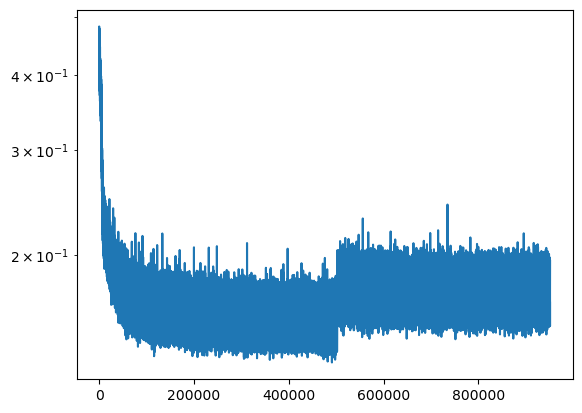

In [353]:
plt.plot(losses)
plt.yscale('log')
#plt.xscale('log')

print(np.mean(losses[-100:]))

In [354]:
#batch['data'] = batch['data'].at[4,start_indx-3].set(vocab_map('(0,0)')).at[4,start_indx-2].set(vocab_map('(0,0)'))

#preds, act = model.apply(state['params'],batch['data'])

#for i in range(20):
#  print(f'\nex {i}')

#  print(batch['data'][i,batch['start_index'][i]:batch['end_index'][i]+1])
#  print(jnp.argmax(preds[i,batch['start_index'][i]:batch['end_index'][i]-1],axis=-1))
#  plot = MazePlot(batch['maze'][i])
#  path = ints_to_coords(jnp.argmax(preds[i,batch['start_index'][i]:batch['end_index'][i]-1],axis=-1))
#  plot.add_predicted_path(path)
#  plot.plot()

In [355]:
maze_num = 0

x_mod = np.copy(batch['data'])
#x_mod[2,x['start_index'][maze_num]+2:x['start_index'][maze_num]+11] = jnp.array([
#    vocab_map('(0,3)'),vocab_map('(0,4)'),vocab_map('(1,4)'),vocab_map('(2,4)'),vocab_map('(3,4)'), vocab_map('(3,3)'), vocab_map('(3,2)'),
#    vocab_map('(4,2)'), vocab_map('(4,3)')])

preds, act = model.apply(state['params'],x_mod)

for t in range(11):
  print(f'\ntime step {t}')
  print(sorted([(reverse_map[i],nn.softmax(preds[maze_num][batch['start_index'][maze_num]+t])[i]) for i in range(len(reverse_map))],key=lambda x: -x[1])[:4])


time step 0
[('(0,1)', Array(0.9999975, dtype=float32)), ('(1,2)', Array(4.1659183e-07, dtype=float32)), ('(4,0)', Array(3.718324e-07, dtype=float32)), ('(1,1)', Array(3.154106e-07, dtype=float32))]

time step 1
[('(0,2)', Array(0.71071666, dtype=float32)), ('(0,0)', Array(0.2889846, dtype=float32)), ('(1,1)', Array(0.00012048, dtype=float32)), ('(0,4)', Array(7.873513e-05, dtype=float32))]

time step 2
[('(0,3)', Array(0.9999927, dtype=float32)), ('<PATH_END>', Array(2.6945088e-06, dtype=float32)), ('(0,1)', Array(2.5418838e-06, dtype=float32)), ('(1,2)', Array(7.468763e-07, dtype=float32))]

time step 3
[('(0,4)', Array(0.67418784, dtype=float32)), ('(1,3)', Array(0.32554492, dtype=float32)), ('(0,2)', Array(0.00019357, dtype=float32)), ('(2,4)', Array(1.4754537e-05, dtype=float32))]

time step 4
[('(2,3)', Array(0.99999166, dtype=float32)), ('(0,3)', Array(5.352495e-06, dtype=float32)), ('(3,3)', Array(1.0488019e-06, dtype=float32)), ('(4,3)', Array(5.4239894e-07, dtype=float32))]


# Probe setup & loading

In [460]:
class LinearProbe(nn.Module):

  @nn.compact
  def __call__(self, x):
    # input should be batch_size x n_layers (one probe per layer) x emb_dim
    #y = nn.Dense(features=128)(x)
    #y = nn.relu(y)
    #y = nn.Dense(features=64)(x)
    #y = nn.relu(y)
    # treat the layers as 1 D spatial dimension, the model dim as channel dim
    bs = x.shape[0]
    #print(x.shape)
    W = self.param('W', nn.initializers.xavier_uniform(), (num_layers+1, emb_dim, 4))
    b = self.param('b', nn.initializers.zeros, (num_layers+1, 4))
    assert x.shape == (bs, num_layers+1, emb_dim)
    x = nn.LayerNorm(reduction_axes=2, feature_axes=(1,2))(x)
    y = einsum(W, x, 'l m o, bs l m -> bs l o') + b
    return y

#def concat_acts(act, first_layer, last_layer):
#  assert len(act['stream'])>=last_layer
#  stream = act['stream'][first_layer:last_layer+1]
#  #concat along model dim (i.e. keep batch and sequence positions separate)
# acts = jnp.concatenate(stream,axis=-1)
#  #print(acts.shape)
#  #acts = acts[:,:,:]
#  #print(acts.shape)
#  return acts

def prepare_acts(act):
    assert act['stream'][0].shape[0] == batch_size, act['stream'][0].shape[2] == emb_dim
    seq_len = act['stream'][0].shape[1]
    # note: input has dimensions n_layer x batch_size x sequence_len x emb_dim
    
    acts  = rearrange(act['stream'], 'layer bs seq dim -> (bs seq) layer dim')

    
    # return a tensor in which all seq positions are in one big batch, then layer, then model dim
    assert len(acts.shape)==3
    assert acts.shape == (batch_size * seq_len, num_layers+1, emb_dim)

    return acts, seq_len

In [461]:
# Linear probe training

# Start a new experiment


losses = []
eval_losses = []

#batch = next(iter(train_loader))


key = random.PRNGKey(0)

rng, key = random.split(key)


#print(f'default loss: {jnp.log()}')

pred, act = model.apply(state['params'], batch['data'])

acts, seq_len = prepare_acts(act) # this is just to initialize the probe, so take first sequence position arbitrarily

x = acts

probe = LinearProbe()

tx = optax.adamw(1e-4)

params = probe.init(rng, x)

opt_state = tx.init(params)

probe_state = {'params': params, 'opt_state': opt_state, 'loss': 0., 'step': 0}

@functools.partial(jax.jit, static_argnums=(2,))
def probe_loss_fn(params, batch, reduce_layers = 1):
  pred, act = model.apply(state['params'], batch['data'])
      
  acts, seq_len = prepare_acts(act)
  assert seq_len == batch['data'].shape[1]

  targets = batch['data'][jnp.arange(0,pred.shape[0]),batch['end_index']-1]

  #print(targets)

  new_targets = targets.copy()

  for k, v in target_dict.items():
      new_targets = jnp.where(targets==k,v,new_targets)

  #print(new_targets)
  # expanding targets along seq len (result is shape 
  repeated_targets = jnp.repeat(new_targets, seq_len, axis = 0)
  assert repeated_targets.shape == (seq_len * batch_size,)
  repeated_targets = jnp.repeat(repeated_targets[:,None], num_layers+1, axis=1)
  assert repeated_targets.shape == (seq_len * batch_size,num_layers+1)
  

  probe_pred = probe.apply(params, acts)

  # probe preds are of shape (batch_size * seq_len, num_layer, 4)

  assert repeated_targets.shape == probe_pred.shape[:-1]

  assert len(repeated_targets.shape)==2

  loss = optax.softmax_cross_entropy_with_integer_labels(
      logits = probe_pred,
      labels = repeated_targets
  )

  # loss is of shape (batch_size * seq_len, num_layer). First, undo the reshaping.

  loss = rearrange(loss, '(bs seq) layer -> bs seq layer', bs=batch_size, seq=seq_len, layer=num_layers+1)
  
  idx = jnp.arange(seq_len)[None, :]

  mask = jnp.where((idx < batch['end_index'][:, None]) & (idx > batch['start_index'][:, None]), 1., 0.)

  # need to broadcast mask over the last layer dimension
  assert mask.shape == (batch_size,seq_len)
  loss = loss * mask[:,:,None]

  if reduce_layers:
      # just add up losses over all the layers. that's fine.
      loss = loss.sum() / mask.sum()
  else:
      loss = loss.sum(axis=(0,1))/mask.sum()

  return loss

@jax.jit
def probe_train_step(probe_state,batch):
  params = probe_state['params']
  opt_state = probe_state['opt_state']
  loss, grads = jax.value_and_grad(probe_loss_fn)(params,batch)
  updates, opt_state = tx.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  step = probe_state['step'] + 1

  return {'params': params, 'opt_state': opt_state, 'loss': loss, 'step': step}

@jax.jit
def probe_eval_step(state,batch):
  params = state['params']
  loss = probe_loss_fn(params,batch)
  return loss

probe_losses = []
probe_eval_losses = []


In [462]:
#@jax.jit
def optimal_loss_fn(batch):

    path_len = batch['true_probs'].shape[1]
    true_probs = batch['true_probs']
    assert true_probs.shape == (batch_size, path_len, 4)
    
    targets = batch['data'][jnp.arange(0,batch['data'].shape[0]),batch['end_index']-1]
    new_targets = targets.copy()
    
    for k, v in target_dict.items():
      new_targets = jnp.where(targets==k,v,new_targets)

    #print(new_targets)
    # expanding targets along seq len (result is shape 
    repeated_targets = jnp.repeat(new_targets, path_len, axis = 0)
    assert repeated_targets.shape == (path_len * batch_size,)

    true_probs_reshaped = rearrange(true_probs, 'bs seq i -> (bs seq) i')
    assert true_probs_reshaped.shape == (path_len * batch_size, 4)

    log_probs = jnp.log(true_probs_reshaped)

    #print(log_probs[:10])
    #print(repeated_targets[:10])

    loss = optax.softmax_cross_entropy_with_integer_labels(
          logits = log_probs,
          labels = repeated_targets
      )
    #print(loss[:10])
    
    # loss is of shape (batch_size * seq_len). First, undo the reshaping.
    
    loss = rearrange(loss, '(bs seq) -> bs seq ', bs=batch_size, seq=path_len)
    
    idx = jnp.arange(path_len)[None, :]
    
    mask = jnp.where((idx <= batch['true_probs_end_index'][:, None]), 1., 0.)
    
    assert mask.shape == (batch_size,path_len)
    loss = np.ma.array(loss, mask=1-mask)
    #print(loss[:10])

    loss = loss.mean()
    
    return loss

In [463]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
probe_options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=keep_n_checkpoints)
probe_checkpoint_manager = orbax.checkpoint.CheckpointManager(os.path.join(base_path,'probe_layernorm_bias'), orbax_checkpointer, probe_options)

In [464]:
# PROBE LOADING
dummy_dict = {
            'probe_state': probe_state,
            'probe_loss': np.zeros(1)}

step = probe_checkpoint_manager.latest_step()
print(f'loading step {step}')
load_dict = probe_checkpoint_manager.restore(step, items=dummy_dict)
probe_state = load_dict['probe_state']
probe_losses = list(load_dict['probe_loss'])
print(np.mean(probe_losses[-100:]))

loading step 37579
12.822217


In [368]:
probe_state['params']

{'params': {'LayerNorm_0': {'bias': array([[ 1.46136492e-01, -8.77346471e-03,  1.12937234e-01, ...,
           -1.30453363e-01, -2.02436954e-01, -2.10518926e-01],
          [ 4.93021347e-02,  1.35792717e-02,  8.51903949e-03, ...,
           -1.53560834e-02,  1.38207412e-04, -1.96253732e-02],
          [ 5.20513207e-02,  2.55328268e-02, -9.20497347e-03, ...,
           -1.87993830e-03,  2.70111468e-02, -2.93347519e-02],
          ...,
          [ 2.90016904e-02,  2.97145545e-02, -1.86522324e-02, ...,
            1.43045383e-02,  1.18656727e-02, -9.23782960e-03],
          [-1.62485261e-02, -1.67717040e-02, -8.45185760e-03, ...,
           -1.44531755e-02,  5.23329489e-02,  1.75085068e-02],
          [-2.32424513e-02, -2.09409408e-02, -7.71074370e-03, ...,
            3.20942444e-03, -1.51730673e-02, -2.12185197e-02]], dtype=float32),
   'scale': array([[0.5295801 , 0.9104292 , 0.8477403 , ..., 0.92662424, 0.7894377 ,
           0.67796063],
          [0.97785205, 1.074334  , 1.2164325 ,

12.818951
18.021826694558577
1.3862943611198906
best layer loss: 0.826928436756134, layer: 11
using act after layer: 0
loss: 1.2811269760131836
using act after layer: 1
loss: 1.1133865118026733
using act after layer: 2
loss: 1.073201298713684
using act after layer: 3
loss: 1.0346379280090332
using act after layer: 4
loss: 1.0464731454849243
using act after layer: 5
loss: 1.0348843336105347
using act after layer: 6
loss: 1.0195246934890747
using act after layer: 7
loss: 0.9678005576133728
using act after layer: 8
loss: 0.9495194554328918
using act after layer: 9
loss: 0.9081009030342102
using act after layer: 10
loss: 0.8296740055084229
using act after layer: 11
loss: 0.826928436756134
using act after layer: 12
loss: 0.8514060378074646


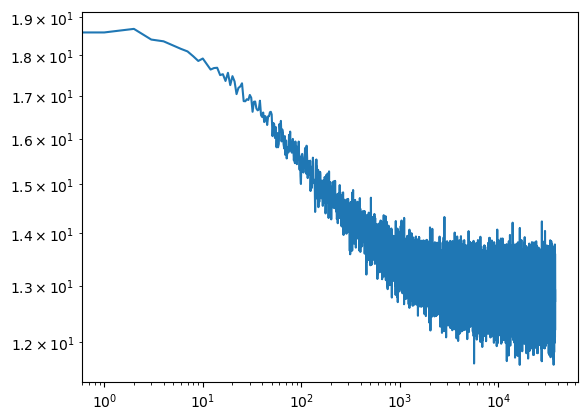

In [465]:
plt.plot(probe_losses)
plt.yscale('log')
plt.xscale('log')

batch_no_maze = {key: val  for key, val in batch.items() if key not in ['maze']}

print(np.mean(probe_losses[-200:]))
print(-13*np.log(1/4))
print(-np.log(1/4))

#optimal_loss = optimal_loss_fn(batch_no_maze)
#print(f'optimal_loss: {optimal_loss}')
layer_losses = probe_loss_fn(probe_state['params'],batch_no_maze,reduce_layers=False)
layer, best_layer_loss = layer_losses.argmin(), layer_losses.min()
print(f'best layer loss: {best_layer_loss}, layer: {layer}')

loss = probe_loss_fn(probe_state['params'], batch_no_maze, reduce_layers = False)

for layer in range(13):
    print(f'using act after layer: {layer}')
    print(f'loss: {loss[layer]}')

In [73]:
embeddings = jnp.array(state['params']['params']['decoder']['Embed_0']['embedding'])

def get_baseline_features(data):
    # Baseline features:
    # for simplicity, we just concatenate the embeddings of the past two tokens.
    data = jnp.array(data)
    features = embeddings[data]

    two_step_features = jnp.concatenate([features[:,:-1,:],features[:,1:,:]],axis=-1)
    seq_len = two_step_features.shape[1]
    out = rearrange(two_step_features, 'bs seq feat -> (bs seq) feat')

    return out, seq_len
    

n_baseline_probe_layers = 3
n_hidden = emb_dim

class BaselineProbe(nn.Module):
    @nn.compact
    def __call__(self, x):
        for layer in range(n_baseline_probe_layers):
            x = nn.Dense(n_hidden)(x)
            x = nn.relu(x)
        out = nn.Dense(4)(x)
        return out

In [74]:
# Linear probe training

# Start a new experiment

losses = []
eval_losses = []

#batch = next(iter(train_loader))


key = random.PRNGKey(0)

rng, key = random.split(key)

baseline_probe = BaselineProbe()

x, seq_len = get_baseline_features(batch['data'])

tx = optax.adamw(1e-4)

params = baseline_probe.init(rng, x)

opt_state = tx.init(params)

baseline_state = {'params': params, 'opt_state': opt_state, 'loss': 0., 'step': 0}

@jax.jit
def baseline_loss_fn(params, batch):
  inputs, seq_len = get_baseline_features(batch['data'])
      
  assert seq_len == batch['data'].shape[1] - 1

  targets = batch['data'][jnp.arange(0,batch_size),batch['end_index']-1]

  new_targets = targets.copy()

  for k, v in target_dict.items():
      new_targets = jnp.where(targets==k,v,new_targets)

  #print(new_targets)
  # expanding targets along seq len (result is shape 
  repeated_targets = jnp.repeat(new_targets, seq_len, axis = 0)
  assert repeated_targets.shape == (seq_len * batch_size,)

  probe_pred = baseline_probe.apply(params, inputs)

  assert repeated_targets.shape == probe_pred.shape[:-1]

  assert len(repeated_targets.shape)==1

  loss = optax.softmax_cross_entropy_with_integer_labels(
      logits = probe_pred,
      labels = repeated_targets
  )

  # loss is of shape (batch_size * seq_len, num_layer). First, undo the reshaping.

  loss = rearrange(loss, '(bs seq) -> bs seq', bs=batch_size, seq=seq_len)
  
  idx = jnp.arange(seq_len)[None, :]

  mask = jnp.where((idx < batch['end_index'][:, None]-1) & (idx > batch['start_index'][:, None]-1), 1., 0.)

  # need to broadcast mask over the last layer dimension
  assert mask.shape == (batch_size,seq_len)
  loss = loss * mask
  loss = loss.sum()/mask.sum()

  return loss

@jax.jit
def baseline_train_step(baseline_state,batch):
  params = baseline_state['params']
  opt_state = baseline_state['opt_state']
  loss, grads = jax.value_and_grad(baseline_loss_fn)(params,batch)
  updates, opt_state = tx.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  step = baseline_state['step'] + 1

  return {'params': params, 'opt_state': opt_state, 'loss': loss, 'step': step}

baseline_losses = []


In [77]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
baseline_options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=keep_n_checkpoints)
baseline_checkpoint_manager = orbax.checkpoint.CheckpointManager(os.path.join(base_path,'baseline_probe'), orbax_checkpointer, baseline_options)

In [78]:
# PROBE LOADING
dummy_dict = {
            'baseline_state': baseline_state,
            'baseline_loss': np.zeros(1)}

step = baseline_checkpoint_manager.latest_step()
print(f'loading step {step}')
load_dict = baseline_checkpoint_manager.restore(step, items=dummy_dict)
baseline_state = load_dict['baseline_state']
baseline_losses = list(load_dict['baseline_loss'])
print(np.mean(baseline_losses[-100:]))

loading step None


FileNotFoundError: Checkpoint at data/baseline_probe/None/default not found.

In [ ]:
dataset = CustomMazeDataset(include_maze=False,no_loops=True)
train_loader = NumpyLoader(dataset, batch_size=batch_size, num_workers=n_worker)

loop_time = time.time()

for n, batch in enumerate(train_loader):
    # do the actual training


    baseline_state = baseline_train_step(baseline_state, batch)
    
    baseline_losses.append(baseline_state['loss'])
    
    print(f'step: {baseline_state["step"]}')
    print('loss: {}'.format(baseline_state['loss']))
    old_time = loop_time
    loop_time = time.time()
    print('steps per second: {:.5f}'.format(1/(loop_time - old_time)))

    if n % 100 == 0:

        baseline_save_step = baseline_state['step']
        print(f'saving at step {baseline_save_step}')
        baseline_save_dict = {'baseline_state': baseline_state,
                     'baseline_loss': np.array(baseline_losses)
                     }
        baseline_save_args = orbax_utils.save_args_from_target(baseline_save_dict)
        baseline_checkpoint_manager.save(baseline_save_step, baseline_save_dict, save_kwargs={'save_args': baseline_save_args})

step: 1
loss: 1.4442585706710815
steps per second: 0.27446
saving at step 1
step: 2
loss: 1.4551637172698975
steps per second: 2.10909
step: 3
loss: 1.3909168243408203
steps per second: 12.77271
step: 4
loss: 1.411695122718811
steps per second: 2.44394
step: 5
loss: 1.366523027420044
steps per second: 2.52664
step: 6
loss: 1.3708125352859497
steps per second: 9.85541
step: 7
loss: 1.3419747352600098
steps per second: 10.18799
step: 8
loss: 1.3524032831192017
steps per second: 9.67415
step: 9
loss: 1.326991081237793
steps per second: 5.06848
step: 10
loss: 1.3308806419372559
steps per second: 5.59290
step: 11
loss: 1.3297613859176636
steps per second: 2.37800
step: 12
loss: 1.3255938291549683
steps per second: 2.43869
step: 13
loss: 1.31077241897583
steps per second: 11.02778
step: 14
loss: 1.31758451461792
steps per second: 8.85923
step: 15
loss: 1.3086975812911987
steps per second: 9.88395
step: 16
loss: 1.2979024648666382
steps per second: 6.02384
step: 17
loss: 1.2884246110916138
st

1.1462948
1.3862943611198906


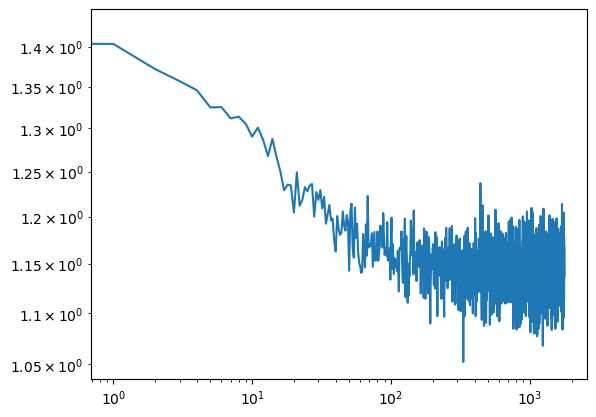

In [72]:
plt.plot(baseline_losses)
plt.yscale('log')
plt.xscale('log')

print(np.mean(baseline_losses[-100:]))
print(-np.log(1/4))

# Probe analysis

In [466]:
def get_probe_probs(probe_params, act):
      
  acts, seq_len = prepare_acts(act)

  probe_preds = probe.apply(probe_params, acts)

  probe_probs = nn.softmax(probe_preds, axis=-1)

  #undo the batching again. Have a new dimension with the 4 probe probabilities now

  return rearrange(probe_probs, '(bs seq) layer pred -> bs seq layer pred', bs=batch_size, seq=seq_len)

reverse_target_dict = {v:k for k,v in target_dict.items()}

In [467]:
dataset = CustomMazeDataset(include_maze=True, no_loops=False)
train_loader = NumpyLoader(dataset, batch_size=batch_size, num_workers=0)

batch = next(iter(train_loader))

print(reverse_target_dict)

{0: 11, 1: 27, 2: 29, 3: 35}


In [418]:
import pickle

# saving batched used for analysis for reproducibility

#with open('analysis_batch.pkl', 'wb') as file:
#    pickle.dump(batch, file)

In [424]:
with open('analysis_batch.pkl', 'rb') as file:
    batch = pickle.load(file)

In [425]:
print(batch['fork_indx'][3])
print(batch['fork_indx_end_index'][3])

KeyError: 'fork_indx'

In [426]:
print(batch['true_probs'][4])
print(batch['true_probs_end_index'][4])
print(batch['true_probs'][4][batch['true_probs_end_index'][4]])

KeyError: 'true_probs'


ex 7
[ 6 16 21 29  7]
[16 21 29]

ex 2
[ 6 28 30 25 20 15 12 11  7]
[28 30 25 20 15 12 11]

ex 3
[ 6 26 34 35 33 28 23 19 17 15 12 14 13 11  7]
[26 34 35 33 28 23 19 17 15 12 14 13 11]

ex 8
[ 6 25 30 28 23 19 24 22 18 14 12 11  7]
[25 30 28 23 19 24 26 18 14 12 11]

ex 9
[ 6 22 24 32 34 35  7]
[22 24 19 34 35]

ex 6
[ 6 32 24 26 33 28 30 27 20 15 17 19 18 14 12 11  7]
[32 24 26 33 28 30 27 20 15 17 19 18 14 12 11]


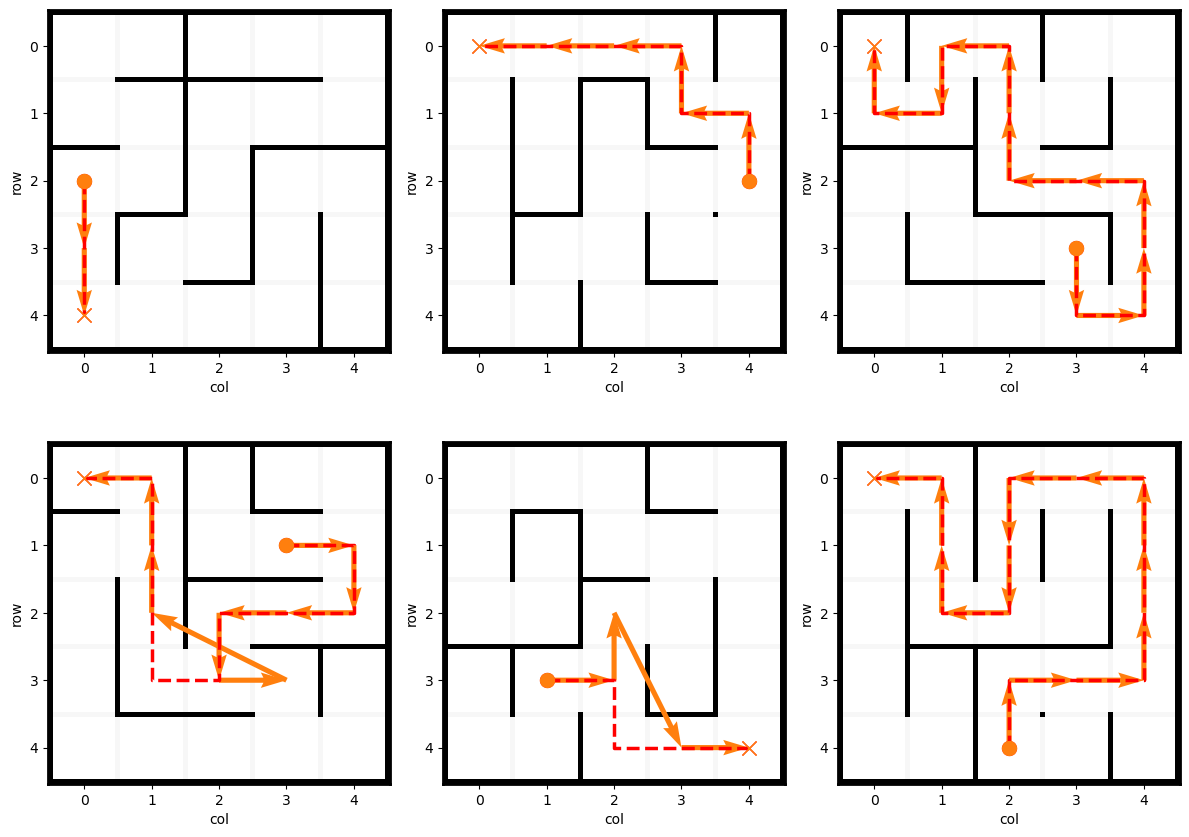

In [454]:
# first, print the mazes

preds, act = model.apply(state['params'],batch['data'])

fig, axs = plt.subplots(2,3, figsize=(12,9))
for n, i in enumerate([7,2,3,8,9,6]):
  print(f'\nex {i}')

  print(batch['data'][i,batch['start_index'][i]:batch['end_index'][i]+1])
  print(jnp.argmax(preds[i,batch['start_index'][i]:batch['end_index'][i]-1],axis=-1))
  plot = MazePlot(batch['maze'][i])
  path = ints_to_coords(jnp.argmax(preds[i,batch['start_index'][i]:batch['end_index'][i]-1],axis=-1))
  plot.add_predicted_path(path)
  plot.plot(fig_ax = (fig, axs[n//3,n%3]))

plt.tight_layout()
plt.savefig('maze_plots.pdf')

[ 0 16  8 13  9 33  8 35  9 24  8 22  9 18  8 14  9 22  8 18  9 34  8 26
  9 30  8 25  9 19  8 23  9 29  8 21  9 14  8 13  9 27  8 20  9 17  8 25
  9 12  8 11  9 21  8 16  9 23  8 28  9 30  8 27  9 24  8 26  9 15  8 17
  9 35  8 34  9 31  8 29  9 32  8 31  9 34  8 32  9 30  8 28  9 19  8 24
  9 14  8 12  9  1  4 25  5  6 25 30 28 23 19 24 22 18 14 12 11  7 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1]
24 26
<-->
[ 0 16  8 13  9 33  8 35  9 24  8 22  9 18  8 14  9 22  8 18  9 34  8 26
  9 30  8 25  9 19  8 23  9 29  8 21  9 14  8 13  9 27  8 20  9 17  8 25
  9 12  8 11  9 21  8 16  9 23  8 28  9 30  8 27  9]
[15  8 17  9 35  8 34  9 31  8 29  9 32  8 31  9 34  8 32  9 30  8 28  9
 19  8 24  9 14  8 12  9  1  4 25  5  6 25 30 28 23 19 24 22 18 14 12 11
  7 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[0, 16, 8, 13, 9, 33, 8, 35, 9, 24, 8, 22, 9, 18, 8, 14, 9, 22, 8, 18, 9, 34, 8, 26, 9, 30, 8, 25, 9, 19, 8, 23, 9, 29, 8, 21, 9, 14, 8, 13, 9, 27, 8, 20, 9, 17, 8, 25, 9, 12, 8, 11, 9, 21, 8, 16, 9, 23, 8, 28, 9

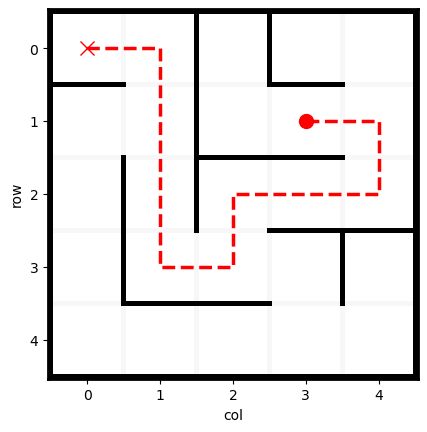

In [435]:
maze_num = 8
cut_start = 65
cut_end = 69

plot = MazePlot(batch['maze'][maze_num])
plot.plot()

print(batch['data'][maze_num])
print(vocab_map('(3,2)'), vocab_map('(3,3)'))
print(reverse_map[8])
print(batch['data'][maze_num][:cut_start])
print(batch['data'][maze_num][cut_end:])
print(list(batch['data'][maze_num][:cut_start])+list(batch['data'][maze_num][cut_end:]))



In [450]:

timestep = 0
#goal_i = target_dict[vocab_map('(0,0)')]
#alpha = 100.
#n_steps = 2
#min_layer = 4

path_probe_probs = [[],[],[],[]]

import copy

x_mod = copy.deepcopy(batch)

# remove path from (4,0) to (4,1
#new_sample = jnp.concatenate([batch['data'][maze_num][:cut_start], batch['data'][maze_num][cut_end:], jnp.array([-1,-1,-1,-1])], axis=0)

#x_mod['data'][maze_num] = new_sample

#x_mod['end_index'][maze_num] = batch['end_index'][maze_num] -4
#x_mod['start_index'][maze_num] = batch['start_index'][maze_num] -4

#x_mod['data'][maze_num][x_mod['start_index'][maze_num]+2] = vocab_map('(1,1)')
#x_mod['data'][maze_num][x_mod['start_index'][maze_num]+7] = vocab_map('(3,4)')
#x_mod['data'][maze_num][x_mod['start_index'][maze_num]+8] = vocab_map('(4,4)')
#x_mod['data'][maze_num][x_mod['start_index'][maze_num]+9] = vocab_map('(4,3)')
#x_mod['end_index'][maze_num]=x['end_index'][maze_num]+1
#intervention = get_intervention(probe_state,alpha=200, min_layer=5, goal_i=target_dict[vocab_map('(4,4)')])
#intervention = get_intervention(probe_state, x_mod, alpha, n_steps, min_layer, goal_i, timestep)
intervention = lambda y,i:y

preds, act = model.apply(state['params'],x_mod['data'], intervention=intervention)
#print(preds[maze_num][timestep])

probe_probs = get_probe_probs(probe_state['params'], act)


for t in range(x_mod['start_index'][maze_num],x_mod['end_index'][maze_num]):
  print('\ntime step {}'.format(t-x_mod['start_index'][maze_num]))
  print('current input {}'.format(reverse_map[x_mod['data'][maze_num][t]]))
  print('maze transformer prediction')
  print(sorted([(reverse_map[i],nn.softmax(preds[maze_num][t])[i]) for i in range(len(reverse_map))],key=lambda x: -x[1])[:4])
  
  for layer in [10]:
      print(f'probe probs layer {layer}:')
      step_probs = sorted([(reverse_map[pos],probe_probs[maze_num][t][layer][i]) for pos, i in target_dict.items()],key=lambda x: -x[1])[:4]
      print(step_probs)
      for i in range(4):
          path_probe_probs[i].append(probe_probs[maze_num][t][layer][i])
  print('target:')
  print(reverse_map[x_mod['data'][maze_num][x_mod['end_index'][maze_num]-1]])


time step 0
current input <PATH_START>
maze transformer prediction
[('(1,3)', Array(0.999998, dtype=float32)), ('(0,4)', Array(5.884495e-07, dtype=float32)), ('(0,2)', Array(5.232775e-07, dtype=float32)), ('(1,2)', Array(3.2214956e-07, dtype=float32))]
probe probs layer 10:
[('(4,0)', Array(0.59035635, dtype=float32)), ('(0,0)', Array(0.18186864, dtype=float32)), ('(4,4)', Array(0.13670644, dtype=float32)), ('(0,4)', Array(0.0910686, dtype=float32))]
target:
(0,0)

time step 1
current input (1,3)
maze transformer prediction
[('(1,4)', Array(0.99999607, dtype=float32)), ('<PATH_END>', Array(1.5565728e-06, dtype=float32)), ('(2,3)', Array(1.2816847e-06, dtype=float32)), ('(0,1)', Array(2.0464108e-07, dtype=float32))]
probe probs layer 10:
[('(4,0)', Array(0.49028617, dtype=float32)), ('(0,0)', Array(0.20954084, dtype=float32)), ('(0,4)', Array(0.16132756, dtype=float32)), ('(4,4)', Array(0.13884549, dtype=float32))]
target:
(0,0)

time step 2
current input (1,4)
maze transformer predict

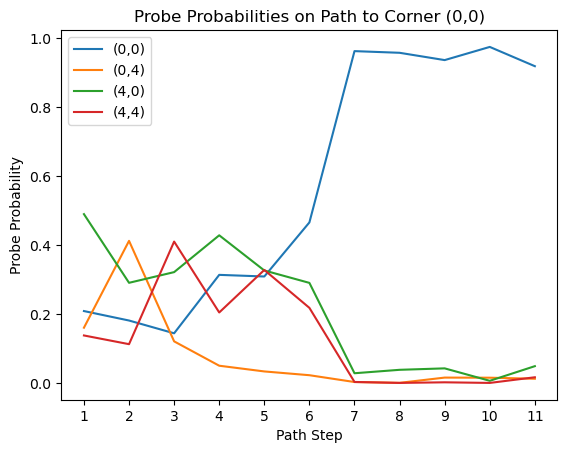

In [459]:


# Plotting the data
for i in range(4):
    plt.plot(range(1,len(path_probe_probs[i])), path_probe_probs[i][1:], label=reverse_map[reverse_target_dict[i]])

plt.xlabel('Path Step')
plt.ylabel('Probe Probability')
plt.title('Probe Probabilities on Path to Corner (0,0)')
plt.xticks(range(1,12))
plt.legend()
plt.savefig('path_probe_probs.pdf')
plt.show()

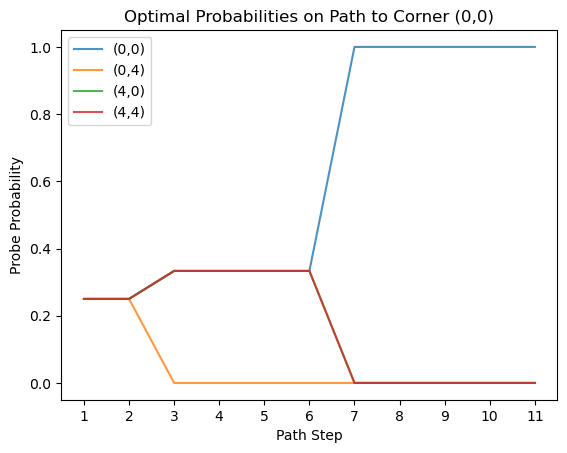

In [492]:
path_probe_probs = [
    [None,0.25,0.25,1/3,1/3,1/3,1/3,1,1,1,1,1],
    [None, 0.25,0.25,0,0,0,0,0,0,0,0,0],
    [None, 0.25,0.25,1/3,1/3,1/3,1/3,0,0,0,0,0],
    [None,0.25,0.25,1/3,1/3,1/3,1/3,0,0,0,0,0],
]


for i in range(4):
    plt.plot(range(1,len(path_probe_probs[i])), path_probe_probs[i][1:], label=reverse_map[reverse_target_dict[i]], alpha=0.8)

plt.xlabel('Path Step')
plt.ylabel('Probe Probability')
plt.title('Optimal Probabilities on Path to Corner (0,0)')
plt.xticks(range(1,12))
plt.legend()
plt.savefig('path_probe_probs_optimal.pdf')
plt.show()

# Causal intervention

In [468]:
dataset = CustomMazeDataset(include_maze=True, no_loops=True)
train_loader = NumpyLoader(dataset, batch_size=batch_size, num_workers=0)
batch = next(iter(train_loader))

In [469]:
# Here, I want to implement causal interventions, for a specific time step
# I want to do it based on gradient descent on the probe outputs, with a specific alpha learning rate
# and number of learning steps (maybe just 1)


def get_intervention(probe_state, x_mod, alpha, n_steps, min_layer, goals, timestep):
    t = (timestep + x_mod['start_index']).astype(int)
    b_i = jnp.arange(len(x_mod['start_index']))
    params = jax.tree_util.tree_map(lambda x: jnp.array(x), probe_state['params'])

    
    def intervention(y,lyr):
        if lyr >= min_layer:
            # first, apply probe on this activation
            # do n_steps gradient descent 

            def loss_fn(y):
                # take only the ys at the specific time step I'm interested in
                #print(b_i.shape)
                #print(t.shape)
                #print(y.shape)
                inputs = y[b_i, t]

                assert inputs.shape == (batch_size, emb_dim)

                # next, repeat along layer dimension (important for applying probe)

                inputs = inputs[:,None,:]

                inputs = inputs.repeat(num_layers+1, axis=1)
                
                assert inputs.shape == (batch_size, num_layers+1, emb_dim)
                
                preds = probe.apply(params, inputs)

                # select the correct layer
                
                preds = preds[:,lyr,:]

                # targets are given
                assert goals.shape == (batch_size,)
                targets = goals

                loss = optax.softmax_cross_entropy_with_integer_labels(
                    logits = preds,
                    labels = targets
                )
                return loss.sum()
                
            for k in range(n_steps):
                loss, grads = jax.jit(jax.value_and_grad(loss_fn))(y)

                y = y - alpha*grads

            
            # compute coefficients for each goal
            #weights = probe_state['params']['params']['W'][lyr][:, goal_i] - probe_state['params']['params']['W'][lyr].mean(axis=-1)
            # coefs, broadcast accross bs and seq, for each probe
            #coefs = einsum(weights, y, 'd, bs seq d -> bs seq')

            #means = reduce(coefs, 'bs seq goal -> seq goal', 'mean')
            #print(means)
            #print(coefs.max(axis=(0,1)))
            #stds = coefs.std(axis=0)
            #print(stds)

            # next, set the coefficients for each of the goals to mean
            # broadcast coefs across model dim
            # 
            #y = y + ((means[None, :, None, :] - coefs[:,:, None, :]) * weights[None, None, :, :]).sum(axis=-1)

            
            

            #y = y.at[b_i,t].set(y[b_i,t]  + alpha * weights[None, :])

            return y
        else:
            return y
    return intervention

In [482]:
# evaluating the causal intervention
# for a given batch, collect the true goal.
# go through the different fork indices for each sample, modify at that step.
# 


alpha = 800.
n_steps = 1
min_layer = 6

# sample new batch for eval
batch = next(iter(train_loader))

n_forks = batch['fork_indx'].shape[1]
assert n_forks == 3


losses = {'baseline':[], 'intervention':[], 'n': []}
probs = {'baseline':[], 'intervention':[], 'n': []}

for i in range(n_forks):
    # baseline pred losses
    
    timestep = (1 + batch['fork_indx'][:,i]).astype(int)
    
    # mask fork indx is -1 -> leads to a timestep of 0. We need to mask that.
    mask = (timestep > 0).astype(float)

    losses['n'].append(mask.sum())
    probs['n'].append(mask.sum())
    
    end_point = batch['data'][jnp.arange(0,batch['data'].shape[0]),batch['end_index']-1]
    goals = copy.deepcopy(end_point)
    
    for k, v in target_dict.items():
      goals = jnp.where(end_point==k,v,goals)

    intervention = get_intervention(probe_state, batch, alpha, n_steps, min_layer, goals, timestep)

    baseline_preds, baseline_act = model.apply(state['params'],batch['data'], intervention=lambda y,i: y)
    
    intervention_preds, intervention_act = model.apply(state['params'],batch['data'], intervention=intervention)

    b_i = jnp.arange(len(batch['start_index']))
    assert b_i.shape == (batch_size,)

    # get the loss for the right time step
    for key, pred in {'baseline':baseline_preds, 'intervention':intervention_preds}.items():
        loss = optax.softmax_cross_entropy_with_integer_labels(
              logits = pred[b_i, timestep + batch['start_index']],
              labels = batch['data'][b_i, timestep+ batch['start_index'] + 1]
          )

        prob = jax.nn.softmax(pred[b_i, timestep + batch['start_index']])[b_i, batch['data'][b_i, timestep+ batch['start_index'] + 1]]
        
        masked_loss = loss * mask
        masked_probs = prob * mask
        losses[key].append(masked_loss)
        probs[key].append(masked_probs)



best diff
[Array(0.12909526, dtype=float32), Array(0.12606394, dtype=float32), Array(0.03350544, dtype=float32)]
corresponding example
[ 6 31 32 34 35 33 28 30 27 20 15 17 14 12 11  7 -1 -1 -1 -1 -1 -1 -1 -1
 -1]
(0,0)


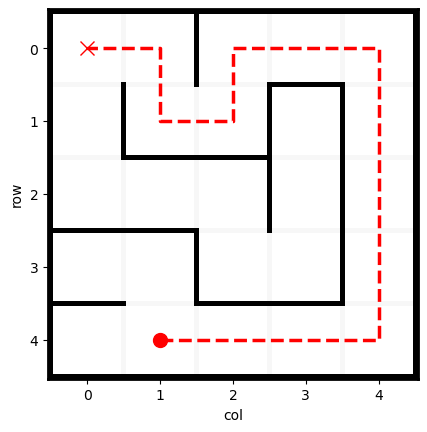

worst diff
[Array(-0.08770972, dtype=float32), Array(-0.04761064, dtype=float32), Array(-0.07304645, dtype=float32)]
avg diff
[Array(0.00941615, dtype=float32), Array(0.00526446, dtype=float32), Array(-0.00177718, dtype=float32)]


In [483]:
#print(losses)
#print(probs)

diffs = [probs['intervention'][i]-probs['baseline'][i] for i in range(3)]

#print(diffs)

print('best diff')
print([arr.max() for arr in diffs])

print('corresponding example')
best_ex = diffs[0].argmax()
print(batch['data'][best_ex][batch['start_index'][best_ex]:])
print(reverse_map[batch['data'][best_ex][batch['end_index'][best_ex]-1]])
plot = MazePlot(batch['maze'][best_ex])
plot.plot()
plt.show()

print('worst diff')
print([arr.min() for arr in diffs])

print('avg diff')
print([arr.sum()/den for arr,den in zip(diffs,probs['n'])])

0.008606948


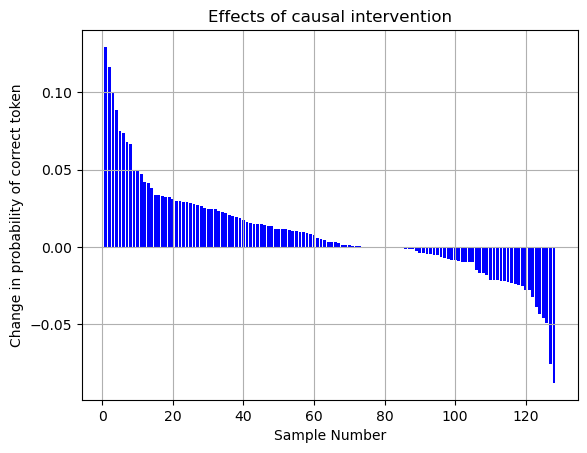

In [484]:
# Creating the histogram
sample_effects = sorted(diffs[0],reverse=True)
print(np.mean(sample_effects))

plt.figure()
plt.bar(range(1, 129), sample_effects, color='blue')
plt.xlabel('Sample Number')
plt.ylabel('Change in probability of correct token')
plt.title('Effects of causal intervention')
plt.grid(True)
plt.savefig('causal_intervention_effect.pdf')
plt.show()

# Logit lens

In [97]:
# Have to extract the unembedding from the model state
# Then apply it to all the captured activations, for each layer
# Print the output distribution for each layer, as well as the loss...

class LogitLens(nn.Module):
    @nn.compact
    def __call__(self, x):
        print(x.shape)
        x = nn.LayerNorm(name='encoderdecoder_norm')(x)
        x = nn.Dense(vocab_size, name='logitdense')(x)
        return x

In [70]:
logitlens = LogitLens()

In [113]:
lens_params = {'params': {key :state['params']['params']['decoder'][key] for key in ['encoderdecoder_norm', 'logitdense']}}

In [109]:
test = logitlens.init(rng, acts)

In [111]:
lens_params['params']['encoderdecoder_norm']['scale'].shape

(256,)

In [110]:
test['params']['encoderdecoder_norm']['scale'].shape

(256,)

In [116]:
logits = logitlens.apply(lens_params, acts)

In [126]:
maze_num = 4
timestep = 4


import copy

x_mod = copy.deepcopy(batch)

#x_mod['data'][maze_num][x_mod['start_index'][maze_num]+2] = vocab_map('(1,1)')
#x_mod['data'][maze_num][x_mod['start_index'][maze_num]+7] = vocab_map('(3,4)')
#x_mod['data'][maze_num][x_mod['start_index'][maze_num]+8] = vocab_map('(4,4)')
#x_mod['data'][maze_num][x_mod['start_index'][maze_num]+9] = vocab_map('(4,3)')
#x_mod['end_index'][maze_num]=x['end_index'][maze_num]+1
#intervention = get_intervention(probe_state,alpha=200, min_layer=5, goal_i=target_dict[vocab_map('(4,4)')])
#intervention = get_intervention(probe_state,x_mod, alpha=100, min_layer=3, goal_i=target_dict[vocab_map('(0,0)')],timestep=timestep)
#intervention = lambda y,i:y

pred, act = model.apply(state['params'],batch['data'])
acts = rearrange(act['stream'], 'layer bs seq d -> bs seq layer d')
logits = logitlens.apply(lens_params, acts)
#print(logits[maze_num][timestep])

#probe_probs = get_probe_probs(probe_state['params'],act)


for t in range(x_mod['start_index'][maze_num],x_mod['end_index'][maze_num]):
    print('\ntime step {}'.format(t-x_mod['start_index'][maze_num]))
    print('current input {}'.format(reverse_map[x_mod['data'][maze_num][t]]))
    print('maze transformer prediction')

  
    for layer in range(13):
        print(f'logit lense layer {layer}:')
        print(sorted([(reverse_map[i],nn.softmax(logits[maze_num][t][layer])[i]) for i in range(len(reverse_map))],key=lambda x: -x[1])[:4])
    print('target:')
    print(reverse_map[x_mod['data'][maze_num][x_mod['end_index'][maze_num]-1]])


time step 0
current input <PATH_START>
maze transformer prediction
logit lense layer 0:
[('(3,4)', Array(0.2587806, dtype=float32)), ('(4,2)', Array(0.17425098, dtype=float32)), ('(4,4)', Array(0.06997302, dtype=float32)), ('(4,0)', Array(0.06530775, dtype=float32))]
logit lense layer 1:
[('(3,4)', Array(0.17567088, dtype=float32)), ('(3,2)', Array(0.08520198, dtype=float32)), ('(4,3)', Array(0.07423946, dtype=float32)), ('(4,2)', Array(0.06740378, dtype=float32))]
logit lense layer 2:
[('(3,4)', Array(0.13202322, dtype=float32)), ('(3,2)', Array(0.11940028, dtype=float32)), ('(4,3)', Array(0.11794285, dtype=float32)), ('(4,1)', Array(0.06585542, dtype=float32))]
logit lense layer 3:
[('(3,4)', Array(0.16497222, dtype=float32)), ('(4,1)', Array(0.09616014, dtype=float32)), ('(4,3)', Array(0.06664094, dtype=float32)), ('(3,2)', Array(0.06429972, dtype=float32))]
logit lense layer 4:
[('(4,1)', Array(0.11799654, dtype=float32)), ('(3,4)', Array(0.09792531, dtype=float32)), ('(3,2)', Arr

In [20]:
np.array([1,np.ones_like(0)])

array([1, 1])

In [ ]:
# I should also use logit lens as a baseline for probing!
# i.e., just remove all values instead of values for the 4 final goals
# and then use that as probing logits and test. Let's do this here.